<a href="https://colab.research.google.com/github/kashyap91/xRay-ImageProcessing/blob/master/Data_analysis_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialisation

In [0]:
!pip uninstall pandas
!pip install 'pandas>=0.24.2'

Uninstalling pandas-0.23.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas-0.23.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-0.23.4
    100% |████████████████████████████████| 10.1MB 4.4MB/s 


In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 26kB/s 


In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1234      0 --:--:-- --:--:-- --:--:--  1234
Updating fastai...
Done.


In [0]:
!python --version

Python 3.6.7


In [0]:
%reload_ext autoreload
%reload_ext numpy
%reload_ext pandas
%reload_ext fastai
%autoreload 2
%matplotlib inline

In [0]:
import pandas as pd
from fastai.vision import *
from fastai.imports import *
from fastai.metrics import error_rate, KappaScore
from fastai.widgets import *
from fastai.callbacks import *
import shutil
import gc
import torch
import os

kappa = KappaScore()
kappa.weights = "quadratic"

In [0]:
pd.__version__ 

'0.24.2'

In [0]:
print('cuda is installed:', torch.cuda.is_available())
print('cudnn is enabled:', torch.backends.cudnn.enabled)

cuda is installed: True
cudnn is enabled: True


# Data Import

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.chdir("/content/gdrive/My Drive/MURA-v1.1/")
!ls -ltra

In [0]:
os.chdir("/content/gdrive/My Drive/test/")
!ls -ltra

total 5
drwx------ 3 root root 4096 Apr 14 11:20 train
-rw------- 1 root root   58 Apr 14 13:31 train_path_with_label_test.csv


In [0]:
path = Path(".")
train = Path("train") 
valid = Path("valid")
path.ls()

[PosixPath('train'), PosixPath('train_path_with_label_test.csv')]

In [0]:
csv_file = 'train_path_with_label_test.csv'
#csv_file = 'train_path_with_label_half.csv' # if you want to run trials runs with limited data
csv_file

'train_path_with_label_test.csv'

In [0]:
pd.set_option('display.max_colwidth', -1)

In [0]:
df = pd.read_csv(csv_file, header=None)
df.head(10)

,0,1
0,train/XR_FOREARM/patient09190/study1_positive/image1.png,1


In [0]:
df_test = pd.read_csv(csv_file, names=['path', 'Abnormal/Normal'])
df_test.head()

In [0]:
df_test[['a','part','b','c','d']] = df_test['path'].str.split('/',expand=True)
df_grp = df_test[['part','Abnormal/Normal']]
df_grp.groupby(['part','Abnormal/Normal']).size()

part         Abnormal/Normal
XR_ELBOW     0                  3160
             1                  2236
XR_FINGER    0                  3352
             1                  2215
XR_FOREARM   0                  1314
             1                  812 
XR_HAND      0                  4330
             1                  1673
XR_HUMERUS   0                  821 
             1                  739 
XR_SHOULDER  0                  4496
             1                  4446
XR_WRIST     0                  6129
             1                  4282
dtype: int64

In [0]:
sns.axes_style()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


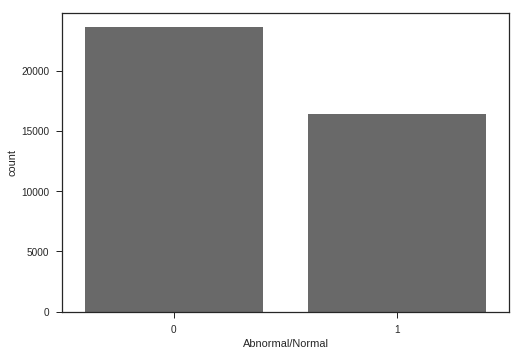

In [0]:
import seaborn as sns
sns.countplot(df_test['Abnormal/Normal'], color='dimgrey')
sns.set()
sns.set_style("ticks")

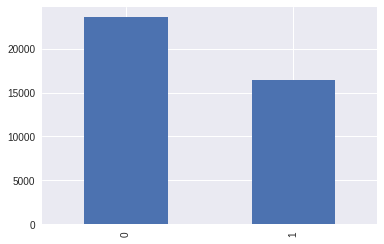

In [0]:

pd.value_counts(df_test['t/f']).plot.bar()

In [0]:
df_test.head()

,path,t/f,a,part,b,c,d
0,train/XR_SHOULDER/patient00001/study1_positive/image1.png,1,train,XR_SHOULDER,patient00001,study1_positive,image1.png
1,train/XR_SHOULDER/patient00001/study1_positive/image2.png,1,train,XR_SHOULDER,patient00001,study1_positive,image2.png
2,train/XR_SHOULDER/patient00001/study1_positive/image3.png,1,train,XR_SHOULDER,patient00001,study1_positive,image3.png
3,train/XR_SHOULDER/patient00002/study1_positive/image1.png,1,train,XR_SHOULDER,patient00002,study1_positive,image1.png
4,train/XR_SHOULDER/patient00002/study1_positive/image2.png,1,train,XR_SHOULDER,patient00002,study1_positive,image2.png


In [0]:
df = df_test.loc[df_test['part'] != 'XR_HAND']

In [0]:
fn_paths = [name for name in df[0]]; #fn_paths[40000:40010]

In [0]:
train.ls()

[PosixPath('train/XR_FOREARM'),
 PosixPath('train/XR_HAND'),
 PosixPath('train/XR_FINGER'),
 PosixPath('train/XR_WRIST'),
 PosixPath('train/XR_HUMERUS'),
 PosixPath('train/XR_ELBOW'),
 PosixPath('train/XR_SHOULDER')]

In [0]:
valid.ls()

[PosixPath('valid/XR_ELBOW'),
 PosixPath('valid/XR_HUMERUS'),
 PosixPath('valid/XR_SHOULDER'),
 PosixPath('valid/XR_WRIST'),
 PosixPath('valid/XR_FOREARM'),
 PosixPath('valid/XR_HAND'),
 PosixPath('valid/XR_FINGER')]

In [0]:
def get_labels(file_path): return '1' if '_positive/' in str(file_path) else '0'

In [0]:
#image size of 256 takes too much time.
#normalizing data
np.random.seed(2)
data = ImageDataBunch.from_name_func(path, fn_paths, label_func=get_labels, bs = 1, ds_tfms=get_transforms(max_warp=25)).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:445: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


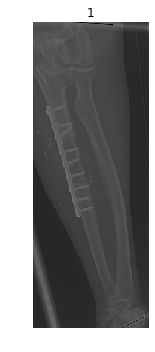

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
len(data.classes),data.c

(1, 1)

In [0]:
torch.cuda.empty_cache()

In [0]:
#normalized image with resnet 50
#fyi: 6 epocs might lead to overfitting -- can be handled via regularization ( yet to look into that )
#to check overfitting, graph with validation error vs no of epocs will reveal if our data is overfitting.
learn = cnn_learner(data, models.resnet50, metrics=[accuracy,error_rate])
#learn.fit_one_cycle(6,callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 19703567.45it/s]


In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________

epoch,train_loss,valid_loss,accuracy,error_rate,kappa_score,time
0,0.487775,0.475014,0.779903,0.220097,0.525958,08:55
1,0.482344,0.474214,0.782777,0.217223,0.527271,08:43
2,0.474727,0.470522,0.783027,0.216973,0.531998,09:05


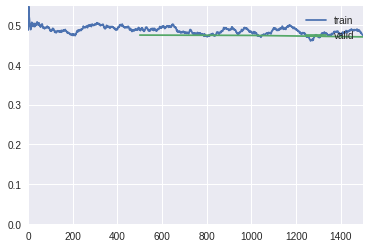

Better model found at epoch 0 with val_loss value: 0.4750136137008667.
Better model found at epoch 1 with val_loss value: 0.4742138683795929.
Better model found at epoch 2 with val_loss value: 0.47052162885665894.


In [0]:
lr=3e-5
learn.fit_one_cycle(3,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

NameError: ignored

In [0]:
learn.save('stage-norm-fit-6-resnet50-kappa-balanced')

In [0]:
import torch
from fastai import *
from fastai.vision import *

In [0]:
loc = torch.load('/content/gdrive/My Drive/MURA-v1.1/models/stage-norm-fit-6-resnet50-kappa.pth')
body = create_body(models.resnet50, True, None)
data_classes = 2
nf = callbacks.hooks.num_features_model(body) * 2
head = create_head(nf, data_classes, None, ps=0.5, bn_final=False)model = nn.Sequential(body, head)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 81618647.62it/s]


In [0]:
learn.load('stage-norm-fit-6-resnet50-kappa')

Learner(data=ImageDataBunch;

Train: LabelList (32004 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (8001 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,0
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In [0]:
#learn.purge()
learn.unfreeze()

In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     True      
______________________________________________________________

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


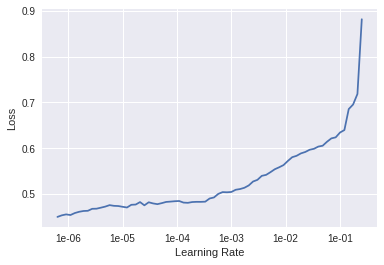

In [0]:
learn.recorder.plot()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

# losses,idxs = interp.top_losses()

# len(data.valid_ds)==len(losses)==len(idxs)

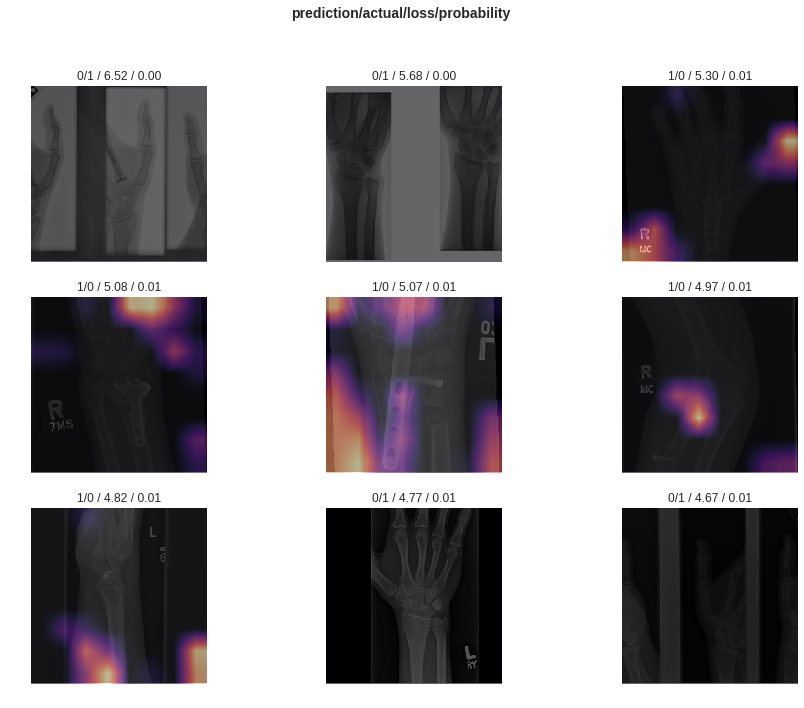

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

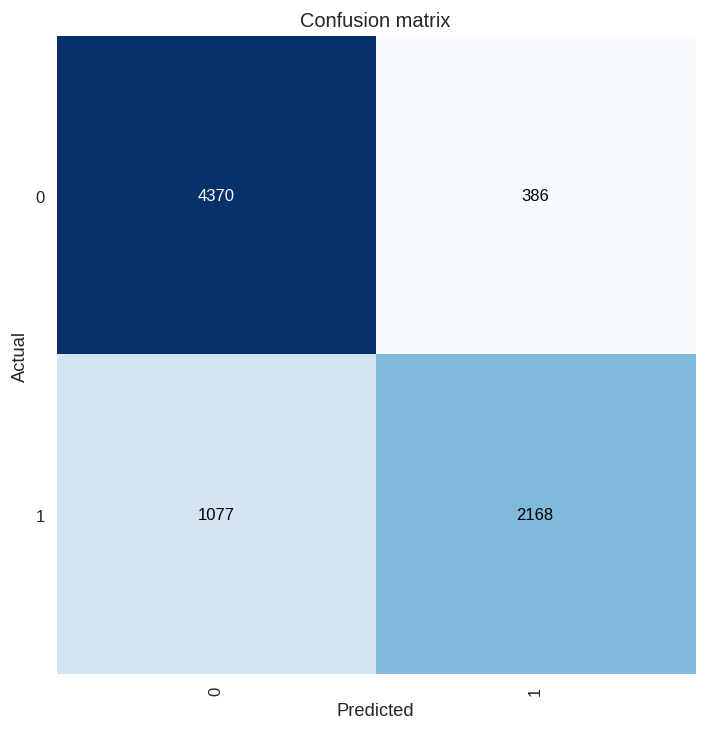

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=120)

In [0]:
learn.recorder.plot_losses()

In [0]:
interp.most_confused(min_val=2)

[('1', '0', 1077), ('0', '1', 386)]

In [0]:
def cal_auc_and_plot(learner):
    preds, y = learner.get_preds()
    probs = np.exp(preds[:,1])
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    return roc_auc

In [0]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

0.870109380932819

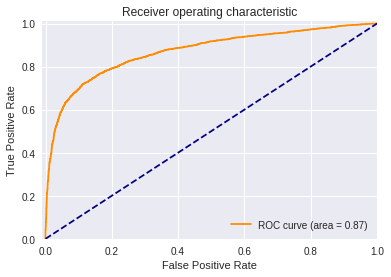

In [0]:
stage1_auc = cal_auc_and_plot(learn)
stage1_auc

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .no_split()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:171: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


In [0]:
learn_cln = cnn_learner(data, models.resnet50, metrics=[accuracy,error_rate,kappa])



In [0]:
learn_cln.load('stage-norm-fit-6-resnet50-kappa')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [0]:
ImageCleaner(ds, idxs, path)

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)